In [1]:
import numpy as np
import pandas as pd
import h5py
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
class labeled_dataset(Dataset):
    def __init__(self):
        data_features = np.loadtxt('./data/labeled_input.txt', dtype=np.float32, delimiter=" ")
        data_labels = np.loadtxt('./data/labels.txt', dtype=np.float32, delimiter=" ")
        self.x = torch.tensor(data_features)
        self.y = torch.tensor(data_labels)
        self.n_samples = data_labels.shape[0]
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]
        
    def __len__(self):
        return self.n_samples
    
class unlabeled_dataset(Dataset):
    def __init__(self):
        data_features = np.loadtxt('./data/unlabeled_input.txt', dtype=np.float32, delimiter=" ")
        data_labels = np.loadtxt('./data/check_labels.txt', dtype=np.float32, delimiter=" ")
        self.x = torch.tensor(data_features)
        self.y = torch.tensor(data_labels)
        self.n_samples = data_features.shape[0]
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]
        
    def __len__(self):
        return self.n_samples

In [3]:
def alpha_weight(t, T_1, T_2, alpha_f):
    if t < T_1:
        return 0
    elif T_2 <= t:
        return alpha_f
    else:
        return (t-T_1)/(T_2-T_1)*alpha_f

In [4]:
def train_supervised(model, train_loader, val_input, val_labels, epochs, save_model=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = torch.nn.BCELoss()
    loss_train_arr = []
    loss_val_arr = []
    acc_arr = []
    auc_arr = []
    bkg_rej = []
    max_bkg_rej = 0
    best_epoch = 0
    for e in range(epochs):
        model.train()
        loss_sum = 0
        for i, (train_input, train_label) in enumerate(train_loader):
            train_input = train_input.to(device)
            train_label = train_label.to(device)
            label_pred = model(train_input)
            loss_train = loss_fn(label_pred, train_label.reshape(-1, 1))
            loss_sum += loss_train.item()
        
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
    
        with torch.no_grad():
            model.eval()
            val_label_pred = model(val_input)
            loss_val = loss_fn(val_label_pred, val_labels.reshape(-1, 1))
            acc_arr.append(1 - torch.sum(torch.abs(val_label_pred.round() - val_labels.reshape(-1, 1))).item()/len(val_labels))
            loss_train_arr.append(loss_sum/(i+1))
            loss_val_arr.append(loss_val.item())
            auc_arr.append(roc_auc_score(val_labels.cpu().detach().numpy(), val_label_pred.cpu().detach().numpy()))
            fpr, tpr, thresholds = roc_curve(val_labels.cpu().detach().numpy(), val_label_pred.cpu().detach().numpy())
            bkg_rej.append(1/fpr[np.argmin(np.abs(tpr-0.3))])
            if bkg_rej[e] > max_bkg_rej:
                torch.save(model.state_dict(), './data/model_1per.pt')
                max_bkg_rej = bkg_rej[e]
                best_epoch = e
                
        if e % 50 == 0:
            print("epoch: %d, loss: %.4f, accuracy: %.4f, AUC: %.4f, background rejection at 30 percent: %.4f" % (e, loss_sum/(i+1), acc_arr[e], auc_arr[e], bkg_rej[e]))
        
        cut_epochs = 10

    plot_learning(epochs, cut_epochs, loss_train_arr, loss_val_arr, acc_arr, auc_arr, bkg_rej)
    print("best epoch: %d" % best_epoch)

In [5]:
def train_semisupervised(model, labeled_loader, unlabeled_loader, val_input, val_labels, epochs, T_1, T_2, alpha_f):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = torch.nn.BCELoss()
    loss_train_arr = []
    loss_val_arr = []
    unlabeled_loss_arr = []
    labeled_loss_arr = []
    acc_arr = []
    auc_arr = []
    bkg_rej = []
    cut_epochs = 10
    for e in range(epochs):
        model.train()
        loss_sum = 0
        loss_sum_labeled = 0
        loss_sum_unlabeled = 0
        for i, (train_input, train_label) in enumerate(labeled_loader):
            train_input = train_input.to(device)
            train_label = train_label.to(device)
            label_pred = model(train_input)
            loss_train = loss_fn(label_pred, train_label.reshape(-1, 1))
            loss_sum_labeled += loss_train.item()
            
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
        loss_sum_labeled /= (i+1)
        loss_sum += loss_sum_labeled
        labeled_loss_arr.append(loss_sum_labeled)
        
        if(e > T_1):
            for j, (train_input, check_labels) in enumerate(unlabeled_loader):
                train_input = train_input.to(device)
                check_labels = check_labels.to(device)
                labels_pred = model(train_input)
                median = torch.median(labels_pred)
                pseudo_labels = torch.where(labels_pred > median, 1., 0.)
                #pseudo_labels = labels_pred.round()
                mask = (check_labels.reshape(-1, 1).cpu().detach().numpy() == pseudo_labels.cpu().detach().numpy()).reshape(1, -1)[0]
                #pseudo_labels = pseudo_labels[mask]
                #labels_pred = labels_pred[mask]
                #loss_train = alpha_weight(e, T_1, T_2, alpha_f) * loss_fn(labels_pred, pseudo_labels.detach())
                loss_train = alpha_weight(e, T_1, T_2, alpha_f) * loss_fn(labels_pred[mask], pseudo_labels[mask].detach())
                #loss_train = alpha_weight(e, T_1, T_2, alpha_f) * loss_fn(pseudo_labels[mask], check_labels.reshape(-1, 1)[mask])
                #loss_train = alpha_weight(e, T_1, T_2, alpha_f) * loss_fn(labels_pred, check_labels.reshape(-1, 1))
                #loss_train = alpha_weight(e, T_1, T_2, alpha_f) * loss_fn(labels_pred[mask], check_labels[mask].reshape(-1, 1))
                loss_sum_unlabeled += loss_train.item()
                optimizer.zero_grad()
                loss_train.backward()
                optimizer.step()
            loss_sum_unlabeled /= (j+1)
            loss_sum += loss_sum_unlabeled      
        unlabeled_loss_arr.append(loss_sum_unlabeled)
        
    
        with torch.no_grad():
            model.eval()
            val_label_pred = model(val_input)
            loss_val = loss_fn(val_label_pred, val_labels.reshape(-1, 1))
            acc_arr.append(1 - torch.sum(torch.abs(val_label_pred.round() - val_labels.reshape(-1, 1))).item()/len(val_labels))
            loss_train_arr.append(loss_sum)
            loss_val_arr.append(loss_val.item())
            auc_arr.append(roc_auc_score(val_labels.cpu().detach().numpy(), val_label_pred.cpu().detach().numpy()))
            fpr, tpr, thresholds = roc_curve(val_labels.cpu().detach().numpy(), val_label_pred.cpu().detach().numpy())
            bkg_rej.append(1/fpr[np.argmin(np.abs(tpr-0.3))])
            #print("epoch: %d, alpha: %.2f, loss: %.4f, labeled loss: %.4f, unlabeled loss: %.4f, accuracy: %.4f, AUC: %.4f, bkg rej @ 0.3: %.4f" % (e, alpha_weight(e, T_1, T_2, alpha_f), loss_sum, loss_sum_labeled, loss_sum_unlabeled, acc_arr[e], auc_arr[e], bkg_rej[e]))        
        if e % 10 == 0:
            print("ep: %d, alpha: %.2f, loss: %.4f, ll: %.4f, ul: %.4f, acc: %.4f, AUC: %.4f, bkg rej @ 0.3: %.4f" % (e, alpha_weight(e, T_1, T_2, alpha_f), loss_sum, loss_sum_labeled, loss_sum_unlabeled, acc_arr[e], auc_arr[e], bkg_rej[e]))        
        if e == T_1:
            evaluate(sesu_model, test_input, test_labels)
        
    plt.plot(range(epochs), labeled_loss_arr, label="loss labeled data")
    plt.legend()
    plt.show()
    plt.plot(range(epochs), unlabeled_loss_arr, label="loss unlabeled data")
    plt.legend()
    plt.show()
    plot_learning(epochs, cut_epochs, loss_train_arr, loss_val_arr, acc_arr, auc_arr, bkg_rej)

In [6]:
def plot_learning(epochs, cut_epochs, loss_train_arr, loss_val_arr, acc_arr, auc_arr, bkg_rej):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
    ax1.plot(range(epochs)[cut_epochs:], loss_train_arr[cut_epochs:], label='loss training set')
    ax1.plot(range(epochs)[cut_epochs:], loss_val_arr[cut_epochs:], label='loss validation set')
    ax1.legend(loc='upper right')
    ax2.plot(range(epochs)[cut_epochs:], acc_arr[cut_epochs:], label='accuracy validation set')
    ax2.plot(range(epochs)[cut_epochs:], auc_arr[cut_epochs:], label='AUC validation set')
    ax2.legend(loc='lower right')
    ax3.plot(range(epochs)[cut_epochs:], bkg_rej[cut_epochs:], label="bkg rej")
    plt.legend()
    plt.show()

In [14]:
def evaluate(model, test_input, test_labels):
    with torch.no_grad():
        model.eval()
        test_label_pred = model(test_input)
        print("accuracy test set: %.4f" % (1 - torch.sum(torch.abs(test_label_pred.round() - test_labels.reshape(-1, 1))).item()/len(test_labels)))
        print("AUC test set: %.4f" % (roc_auc_score(test_labels.cpu().detach().numpy(), test_label_pred.cpu().detach().numpy())))
        fpr, tpr, thresholds = roc_curve(test_labels.cpu().detach().numpy(), test_label_pred.cpu().detach().numpy())
        print("background rejection at 30 percent: %.4f" % (1/fpr[np.argmin(np.abs(tpr-0.3))]))
        plt.semilogy(tpr[fpr>0], 1/fpr[fpr>0]) 
        plt.show()

In [8]:
if torch.cuda.is_available():
    dev = "cuda:0"
    print("running on GPU")
else:
    print("running on CPU")
    dev = "cpu"
    
device = torch.device(dev)

running on CPU


In [9]:
data = np.loadtxt('./data/train_data.txt', dtype=np.float32, delimiter=",", skiprows=1)
labeled_input, unlabeled_input, labels, check_labels = train_test_split(data[:, 1:-6], data[:, [-1]], train_size = 0.01)
np.savetxt('./data/labeled_input.txt', labeled_input)
np.savetxt('./data/unlabeled_input.txt', unlabeled_input)
np.savetxt('./data/labels.txt', labels)
np.savetxt('./data/check_labels.txt', check_labels)

In [10]:
labeled_data = labeled_dataset()
unlabeled_data = unlabeled_dataset()

val_data = np.loadtxt('./data/val_data.txt', dtype=np.float32, delimiter=",", skiprows=1)
val_input = torch.tensor(val_data[:, 1:-6]).to(device)
val_labels = torch.tensor(val_data[:, -1]).to(device)
test_data = np.loadtxt('./data/test_data.txt', dtype=np.float32, delimiter=",", skiprows=1)
test_input = torch.tensor(test_data[:, 1:-6]).to(device)
test_labels = torch.tensor(test_data[:, -1]).to(device)

In [11]:
test_loader = DataLoader(dataset=labeled_data, batch_size=len(labeled_data))
print(np.mean(iter(test_loader).next()[1].tolist()))

0.49888402083161115


In [15]:
model = torch.nn.Sequential(
    torch.nn.Linear(26, 200),
    torch.nn.Dropout(0.2),
    torch.nn.ReLU(),
    torch.nn.Linear(200, 200),
    torch.nn.Dropout(0.2),
    torch.nn.ReLU(),
    torch.nn.Linear(200, 50),
    torch.nn.Dropout(0.1),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 50),
    torch.nn.Dropout(0.1),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 1),
    torch.nn.Sigmoid()
)


sesu_model = torch.nn.Sequential(
    torch.nn.Linear(26, 200),
    torch.nn.Dropout(0.2),
    torch.nn.ReLU(),
    torch.nn.Linear(200, 200),
    torch.nn.Dropout(0.2),
    torch.nn.ReLU(),
    torch.nn.Linear(200, 50),
    torch.nn.Dropout(0.1),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 50),
    torch.nn.Dropout(0.1),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 1),
    torch.nn.Sigmoid()
)

model = model.to(device)
sesu_model = sesu_model.to(device)

epoch: 0, loss: 0.6276, accuracy: 0.7804, AUC: 0.8552, background rejection at 30 percent: 13.8489
epoch: 50, loss: 0.2058, accuracy: 0.9179, AUC: 0.9722, background rejection at 30 percent: 228.7580
epoch: 100, loss: 0.1932, accuracy: 0.9226, AUC: 0.9752, background rejection at 30 percent: 332.1898
epoch: 150, loss: 0.1877, accuracy: 0.9235, AUC: 0.9761, background rejection at 30 percent: 384.9082
epoch: 200, loss: 0.1844, accuracy: 0.9242, AUC: 0.9766, background rejection at 30 percent: 434.7883
epoch: 250, loss: 0.1808, accuracy: 0.9244, AUC: 0.9769, background rejection at 30 percent: 468.1558
epoch: 300, loss: 0.1786, accuracy: 0.9246, AUC: 0.9771, background rejection at 30 percent: 488.6092
epoch: 350, loss: 0.1771, accuracy: 0.9246, AUC: 0.9771, background rejection at 30 percent: 512.2316
epoch: 400, loss: 0.1747, accuracy: 0.9246, AUC: 0.9771, background rejection at 30 percent: 535.3910
epoch: 450, loss: 0.1731, accuracy: 0.9245, AUC: 0.9772, background rejection at 30 pe

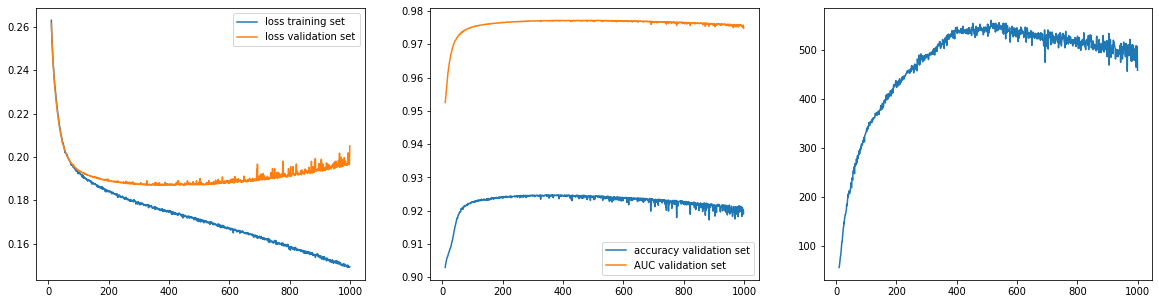

accuracy test set: 0.9202
AUC test set: 0.9753
background rejection at 30 percent: 522.0415


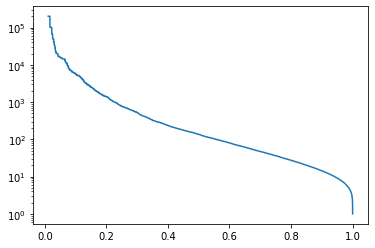

In [212]:
learning_rate = 0.0001
epochs = 200
batch_size = 256

labeled_loader = DataLoader(dataset=labeled_data, batch_size=batch_size, shuffle=True, drop_last=True)

train_supervised(model, labeled_loader, val_input, val_labels, epochs)
model.load_state_dict(torch.load('./data/model_1per.pt'))
evaluate(model, test_input, test_labels)

ep: 0, alpha: 0.00, loss: 0.6697, ll: 0.6697, ul: 0.0000, acc: 0.6761, AUC: 0.8521, bkg rej @ 0.3: 10.8926
ep: 10, alpha: 0.00, loss: 0.2356, ll: 0.2356, ul: 0.0000, acc: 0.9088, AUC: 0.9646, bkg rej @ 0.3: 130.9740
ep: 20, alpha: 0.00, loss: 0.2083, ll: 0.2083, ul: 0.0000, acc: 0.9191, AUC: 0.9722, bkg rej @ 0.3: 239.3662
ep: 30, alpha: 0.00, loss: 0.1999, ll: 0.1999, ul: 0.0000, acc: 0.9222, AUC: 0.9745, bkg rej @ 0.3: 295.6050
ep: 40, alpha: 0.00, loss: 0.1943, ll: 0.1943, ul: 0.0000, acc: 0.9231, AUC: 0.9754, bkg rej @ 0.3: 348.2820
ep: 50, alpha: 0.00, loss: 0.1910, ll: 0.1910, ul: 0.0000, acc: 0.9235, AUC: 0.9762, bkg rej @ 0.3: 385.6456
ep: 60, alpha: 0.00, loss: 0.1875, ll: 0.1875, ul: 0.0000, acc: 0.9239, AUC: 0.9765, bkg rej @ 0.3: 423.8042
ep: 70, alpha: 0.00, loss: 0.1883, ll: 0.1883, ul: 0.0000, acc: 0.9235, AUC: 0.9768, bkg rej @ 0.3: 499.5211
ep: 80, alpha: 0.00, loss: 0.1860, ll: 0.1860, ul: 0.0000, acc: 0.9242, AUC: 0.9771, bkg rej @ 0.3: 500.7637
ep: 90, alpha: 0.00, 

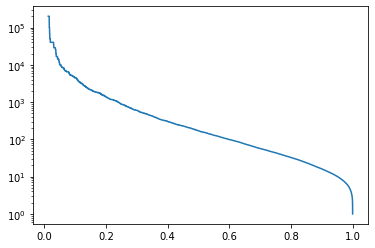

ep: 130, alpha: 0.12, loss: 0.2153, ll: 0.2119, ul: 0.0035, acc: 0.9256, AUC: 0.9784, bkg rej @ 0.3: 422.9139
ep: 140, alpha: 0.25, loss: 0.2254, ll: 0.2186, ul: 0.0068, acc: 0.9272, AUC: 0.9790, bkg rej @ 0.3: 456.4785
ep: 150, alpha: 0.38, loss: 0.2320, ll: 0.2218, ul: 0.0102, acc: 0.9285, AUC: 0.9791, bkg rej @ 0.3: 469.2471
ep: 160, alpha: 0.50, loss: 0.2353, ll: 0.2219, ul: 0.0134, acc: 0.9291, AUC: 0.9791, bkg rej @ 0.3: 410.8306
ep: 170, alpha: 0.62, loss: 0.2502, ll: 0.2334, ul: 0.0168, acc: 0.9289, AUC: 0.9789, bkg rej @ 0.3: 403.4208
ep: 180, alpha: 0.75, loss: 0.2476, ll: 0.2275, ul: 0.0201, acc: 0.9291, AUC: 0.9792, bkg rej @ 0.3: 413.3614
ep: 190, alpha: 0.88, loss: 0.2743, ll: 0.2513, ul: 0.0230, acc: 0.9283, AUC: 0.9791, bkg rej @ 0.3: 425.5962


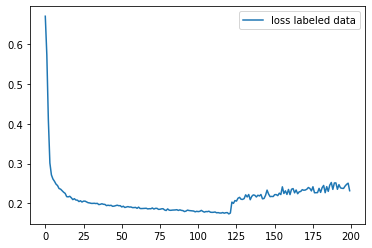

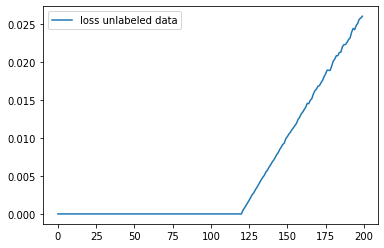

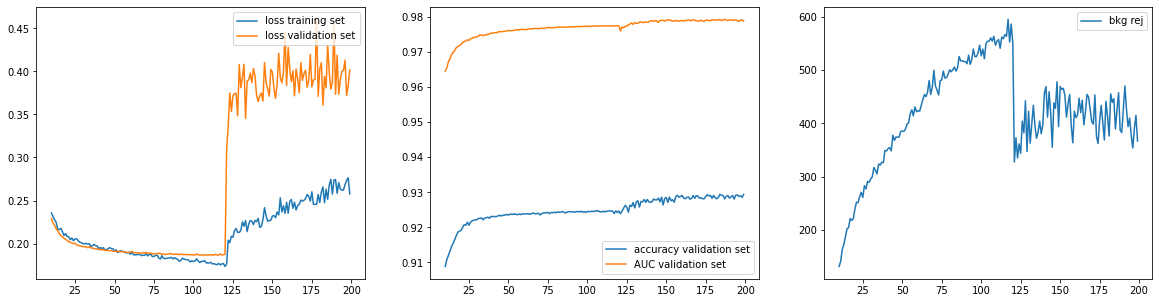

accuracy test set: 0.9303
AUC test set: 0.9796
background rejection at 30 percent: 389.7640


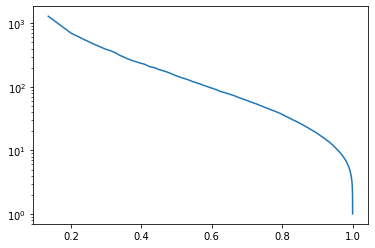

In [16]:
learning_rate = 0.0001
epochs = 200
batch_size_labeled = 256
batch_size_unlabeled = 256
T_1 = 120
T_2 = 200
alpha_f = 1

labeled_loader = DataLoader(dataset=labeled_data, batch_size=batch_size_labeled, shuffle=True, drop_last=True)
unlabeled_loader = DataLoader(dataset=unlabeled_data, batch_size=batch_size_unlabeled, shuffle=True, drop_last=True)

#train_supervised(sesu_model, labeled_loader, val_input, val_labels, 200)
#model.load_state_dict(torch.load('/beegfs/desy/user/schwat/data/model_1per.pt'))
train_semisupervised(sesu_model, labeled_loader, unlabeled_loader, val_input, val_labels, epochs, T_1, T_2, alpha_f)
evaluate(sesu_model, test_input, test_labels)

In [ ]:
evaluate(sesu_model, test_input, test_labels)